# Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Setup

In [1]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

CALIBRATION_IMAGE_FOLDER = 'camera_cal/'
TEST_IMAGE_FOLDER = 'test_images/'
TEST_IMAGE = TEST_IMAGE_FOLDER + 'test2.jpg'

THRESHOLD_RANGE = (140, 255)
DEFAULT_KERNEL_SIZE = 3
LEFT_LANE_COLOR = [255, 0, 0]
RIGHT_LANE_COLOR = [255, 255, 0]
SLIDING_WINDOW_COLOR = (0, 255, 0)
FITTED_CURVE_COLOR='white'
FITTED_CURVE_WIDTH_PX=3
NUMBER_OF_SLIDING_WINDOWS = 9

## Utilities

In [2]:
import os
import scipy.stats as stats

def get_test_image():
    return cv2.imread(TEST_IMAGE)

def get_named_test_image(name):
    return cv2.imread(TEST_IMAGE_FOLDER + name)

def get_all_test_images():
    return TEST_IMAGE_FOLDER, os.listdir(TEST_IMAGE_FOLDER)
    
def display_single_channel_image(img, title):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

"""
Used this during development to find value distribution (to find range)
"""
def draw_bell_curve(arr, min=0, max=10000):
    arr = arr.flatten()
    k = np.sort(arr)
    j = k[k>min]
    h = j[j<max]
    fit = stats.norm.pdf(h, np.mean(h), np.std(h))
    plt.figure()
    plt.plot(h,fit,'-o')
    plt.hist(h,normed=True)
    plt.show()

## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

### 1.1 Computation of camera calibration matrix and distortion coefficients.

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_distortion_vars():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(CALIBRATION_IMAGE_FOLDER + 'calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)

def undistort(img):
    ret, mtx, dist, rvecs, tvecs = get_distortion_vars()
    return cv2.undistort(img, mtx, dist, None, mtx)

### 1.2. Test for image distortion correction on chessboard image

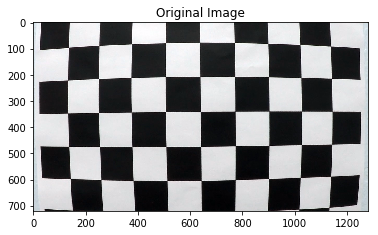

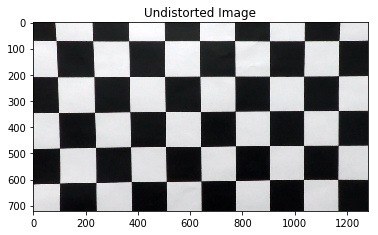

In [4]:
img = cv2.imread(CALIBRATION_IMAGE_FOLDER + 'calibration1.jpg')

plt.title('Original Image')
plt.imshow(img)

plt.figure()
plt.title('Undistorted Image')
undistorted = undistort(img)
plt.imshow(undistorted)

## 2. Apply distortion correction to raw images.

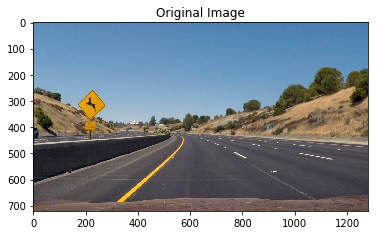

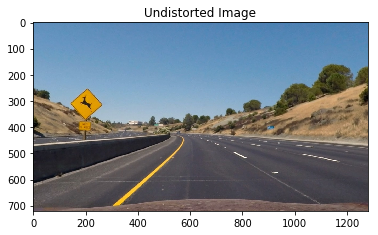

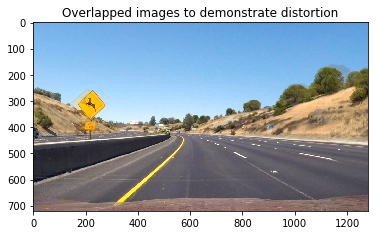

In [5]:
original = get_test_image()
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

plt.title('Original Image')
plt.imshow(rgb)

plt.figure()
plt.title('Undistorted Image')
undistorted = undistort(rgb)
plt.imshow(undistorted)

diff = weighted_img(undistorted, rgb, 0.95, 0.30, 0.)
plt.figure()
plt.title('Overlapped images to demonstrate distortion')
plt.imshow(diff)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

### 3.1 HLS and Color Thresholds

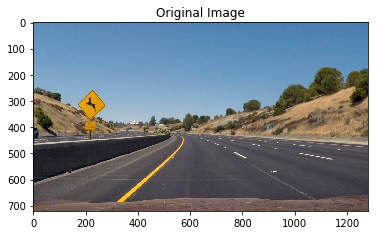

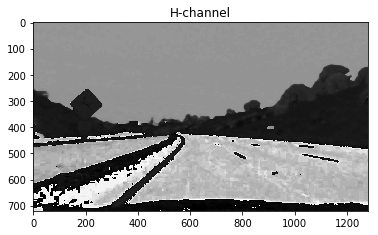

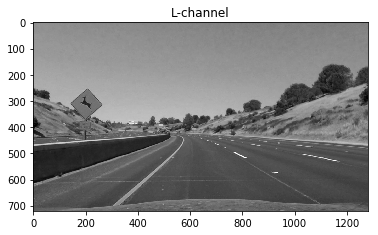

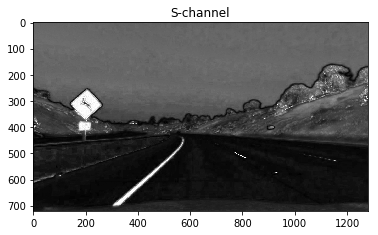

In [6]:
def display_hls_channel_images(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]

    plt.figure()
    rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    plt.title('Original Image')
    plt.imshow(rgb)

    display_single_channel_image(H, 'H-channel')
    display_single_channel_image(L, 'L-channel')
    display_single_channel_image(S, 'S-channel')
    
original = cv2.imread(TEST_IMAGE)
undistorted = undistort(original)
display_hls_channel_images(undistorted)

### 3.2 Threshold codes taken from Course resources

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=DEFAULT_KERNEL_SIZE, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=DEFAULT_KERNEL_SIZE, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # Return the binary image
    return binary_output

# Threshold derived from S channel of the image converted to HLS
def s_channel_threshold(img, thresh):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

def get_thresholds(image):
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=DEFAULT_KERNEL_SIZE, mag_thresh=(10, 100))
    dir_binary = dir_threshold(image, sobel_kernel=DEFAULT_KERNEL_SIZE, thresh=(0.7, 1.3))
    s_channel_binary = s_channel_threshold(image, THRESHOLD_RANGE)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_channel_binary == 1)] = 1
    
    return gradx, grady, mag_binary, dir_binary, s_channel_binary, combined

### 3.3 Example of thresholded image

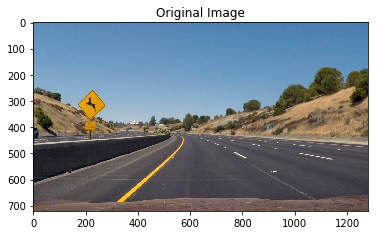

In [8]:
original = get_test_image()
rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
plt.title('Original Image')
plt.imshow(rgb)

undistorted = undistort(original)
threshold = get_thresholds(undistorted)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

### 4.1 Finding street endpoints from a straight road for perspective transform

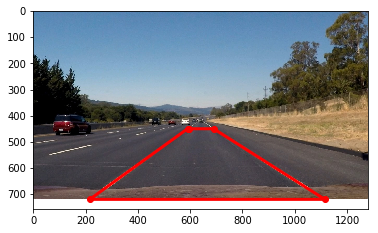

In [9]:
img = get_named_test_image('straight_lines2.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(rgb)
X = [595, 690, 1115, 216, 590]
Y = [450, 450, 720, 720, 450]
plt.plot(X, Y, 'ro-', linewidth=3)

#### We'll go ahead and use the four points - (595, 450), (690, 450), (1115, 720) and (216, 720) from the straight road for perspective transform.

### 4.2 Using the four coordinates from above to perform perspective image on other road image.

In [10]:
def endpoints_for_perspective_transform():
    return np.array([[[595, 450], [690, 450], [1115, 720], [216, 720]]], dtype=np.int32)

def road_mask(img):
    pts = endpoints_for_perspective_transform()
    mask = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    cv2.fillPoly(mask, pts, color=(0, 80, 0))
    return mask

def warp(img, pts, offsetx=200, offsety=0):
    warped = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    height, width = img.shape[0], img.shape[1]
    src = pts[0].astype('float32')
    
    new_window = np.int32([
        [0, 0],
        [width-1, 0],
        [width-1, height-1],
        [0, height]]).astype('float32')
    offset = np.int32([
        [offsetx, offsety],
        [-offsetx, offsety],
        [-offsetx, -offsety],
        [offsetx, -offsety]]).astype('float32')
    dst = new_window + offset
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return warped, M, dst

def unwarp(img, pts, offsetx=200, offsety=0):
    unwarped = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    height, width = img.shape[0], img.shape[1]
    src = pts[0].astype('float32')
    
    new_window = np.int32([
        [0, 0],
        [width-1, 0],
        [width-1, height-1],
        [0, height]]).astype('float32')
    offset = np.int32([
        [offsetx, offsety],
        [-offsetx, offsety],
        [-offsetx, -offsety],
        [offsetx, -offsety]]).astype('float32')
    dst = new_window + offset
    
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    unwarped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    return unwarped, M, dst

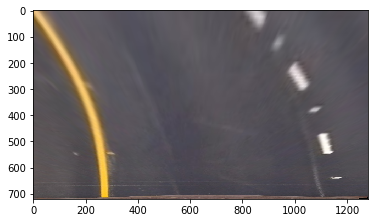

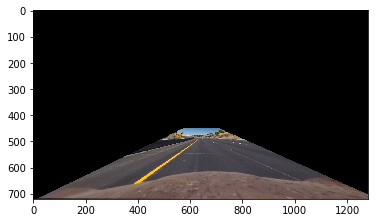

In [11]:
img = get_test_image()
undistorted = undistort(img)
rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

pts = endpoints_for_perspective_transform()
warped, M, dst = warp(rgb, pts)
plt.imshow(warped)

unwarped, M, dst = unwarp(rgb, pts)
plt.figure()
plt.imshow(unwarped)

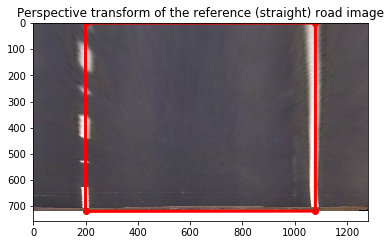

In [12]:
img = get_named_test_image('straight_lines2.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pts = endpoints_for_perspective_transform()
warped, M, dst = warp(rgb, pts, offsetx=200, offsety=0)
plt.figure()
plt.title('Perspective transform of the reference (straight) road image')
plt.imshow(warped)

X = (dst[:,0]).astype(int)
X = np.append(X, X[0])
Y = (dst[:,1]).astype(int)
Y = np.append(Y, Y[0])
plt.plot(X, Y, 'ro-', linewidth=3)

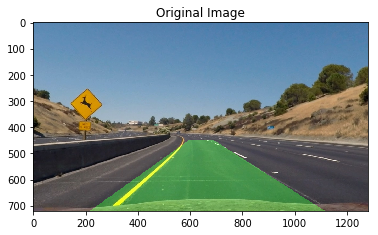

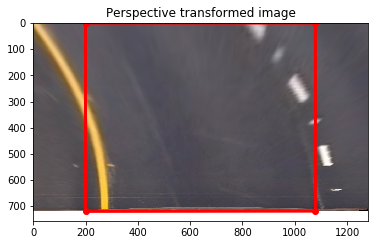

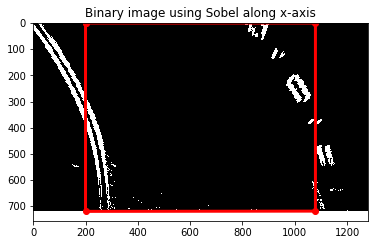

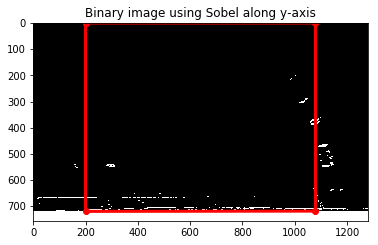

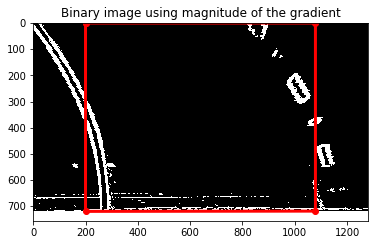

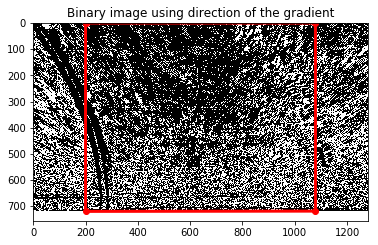

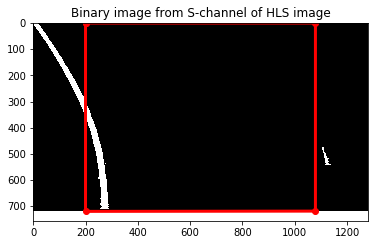

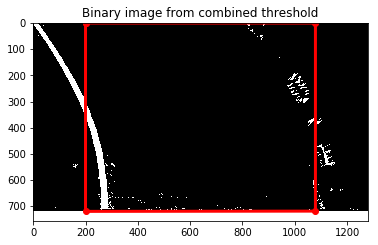

In [13]:
def draw_ref_lines(dst):
    X = (dst[:,0]).astype(int)
    X = np.append(X, X[0])
    Y = (dst[:,1]).astype(int)
    Y = np.append(Y, Y[0])
    plt.plot(X, Y, 'ro-', linewidth=3)

def display_image_with_ref_lines(gray, title, dst):
    display_single_channel_image(gray, title)
    draw_ref_lines(dst)

img = get_test_image()
undistorted = undistort(img)
rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

mask = road_mask(rgb)
overlay = weighted_img(mask, rgb, 0.95, 1., 0)
plt.figure()
plt.title('Original Image')
plt.imshow(overlay)

pts = endpoints_for_perspective_transform()
warped, M, dst = warp(rgb, pts)
plt.figure()
plt.title('Perspective transformed image')
plt.imshow(warped)
draw_ref_lines(dst)

gradx, grady, mag_binary, dir_binary, s_channel_binary, combined = get_thresholds(warped)

display_image_with_ref_lines(gradx, 'Binary image using Sobel along x-axis', dst)
display_image_with_ref_lines(grady, 'Binary image using Sobel along y-axis', dst)
display_image_with_ref_lines(mag_binary, 'Binary image using magnitude of the gradient', dst)
display_image_with_ref_lines(dir_binary, 'Binary image using direction of the gradient', dst)
display_image_with_ref_lines(s_channel_binary, 'Binary image from S-channel of HLS image', dst)
display_image_with_ref_lines(combined, 'Binary image from combined threshold', dst)

## 5. Detect lane pixels and fit to find the lane boundary.

### 5.1 Code from course resource to find lane pixels, and fit polynomial

In [14]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = NUMBER_OF_SLIDING_WINDOWS
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),SLIDING_WINDOW_COLOR, 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),SLIDING_WINDOW_COLOR, 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window
        # (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, x_mult_factor=1, y_mult_factor=1):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty * y_mult_factor, leftx * x_mult_factor, 2)
    right_fit = np.polyfit(righty * y_mult_factor, rightx * x_mult_factor, 2)

    # Generate x and y values for plotting
    maxy = np.int(binary_warped.shape[0]*y_mult_factor)-1
    ploty = np.linspace(0, maxy, maxy+1 )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = LEFT_LANE_COLOR
    out_img[righty, rightx] = RIGHT_LANE_COLOR

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color=FITTED_CURVE_COLOR, linewidth=FITTED_CURVE_WIDTH_PX)
    plt.plot(right_fitx, ploty, color=FITTED_CURVE_COLOR, linewidth=FITTED_CURVE_WIDTH_PX)

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty

### 5.2 Finding lane pixels and curve fitting on a provided test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


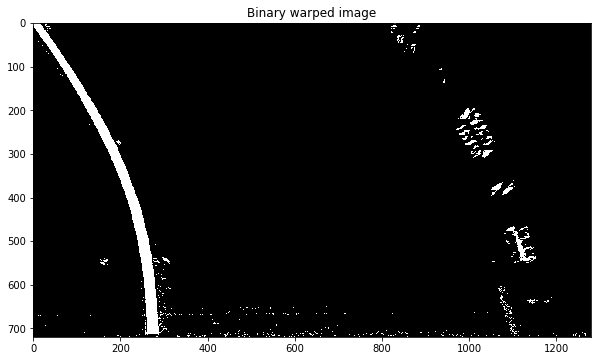

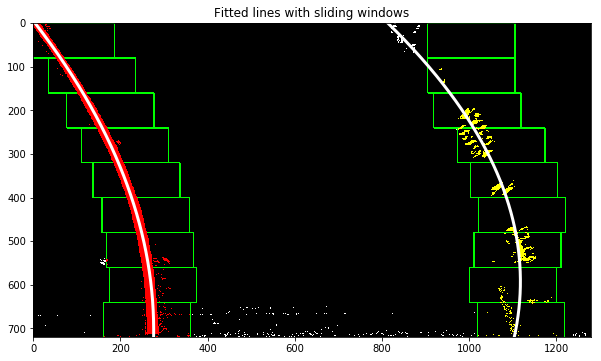

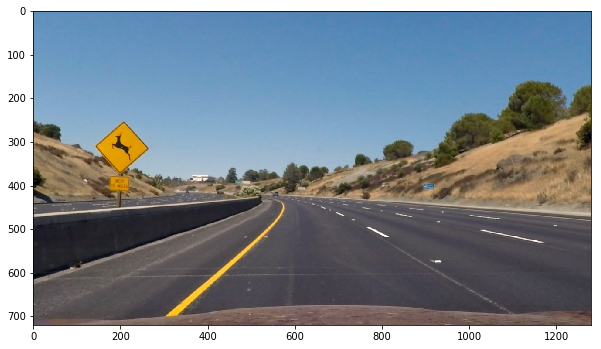

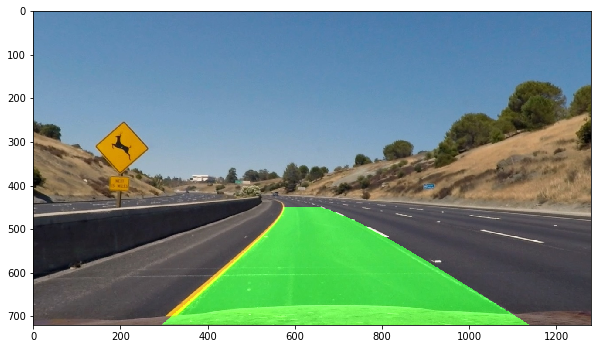

In [15]:
img = get_test_image()
undistorted = undistort(img)
rgb = cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

pts = endpoints_for_perspective_transform()
warped, M, dst = warp(rgb, pts)

gradx, grady, mag_binary, dir_binary, s_channel_binary, combined = get_thresholds(warped)
binary_warped = combined

plt.figure(figsize=(10, 6))
plt.title('Binary warped image')
plt.imshow(binary_warped, cmap='gray')

plt.figure(figsize=(10, 6))
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
plt.title('Fitted lines with sliding windows')
plt.imshow(out_img)

plt.figure(figsize=(10, 6))
plt.imshow(rgb)

plt.figure(figsize=(10, 6))
layer = np.zeros_like(img)
coordinates_left = np.vstack((left_fitx.astype(int), ploty.astype(int))).T
coordinates_right = np.flipud(np.vstack((right_fitx.astype(int), ploty.astype(int))).T)
coordinates = np.concatenate((coordinates_left, coordinates_right), axis=0)
cv2.fillPoly(layer, np.array([ coordinates ]), color=(0, 255, 0))

pts = endpoints_for_perspective_transform()
unwarped, M, dst = unwarp(layer, pts)

overlay = weighted_img(unwarped, rgb, 0.95, 0.6, 0)

plt.imshow(overlay)

## 6. Determine the curvature of the lane and vehicle position with respect to center.

### 6.1. [Using code from course resource], determine lane curvature and vehicle offset w.r.t. center

In [16]:
def radius(fitted_curve, y):
    a0, a1, a2 = fitted_curve
    result = ((1 + (2*a0*y + a1)**2)**1.5) / np.abs(2*a0)
    return result

### 6.2. Determining conversions in x and y from pixels space to meters

Dashed line width (in px): 81
Standard length of dashed line (in meters): 3.0
meters per pixel in y dimension:  0.037037037037037035
Lane width in px: 720.0
Standard width of lanes (in meters): 3.7
meters per pixel in x dimension:  0.005138888888888889


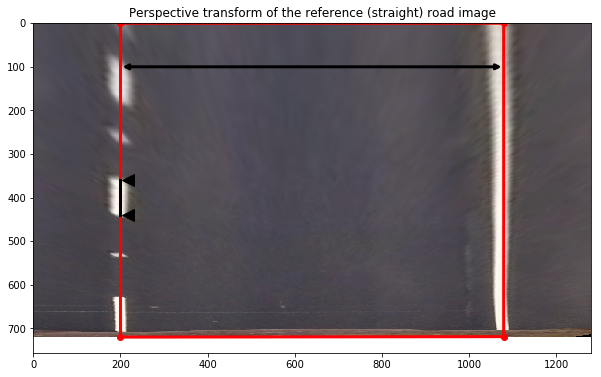

In [17]:
img = get_named_test_image('straight_lines2.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pts = endpoints_for_perspective_transform()
warped, M, dst = warp(rgb, pts, offsetx=200, offsety=0)
plt.figure(figsize=(10, 10))
plt.title('Perspective transform of the reference (straight) road image')
plt.imshow(warped)

X = (dst[:,0]).astype(int)
X = np.append(X, X[0])
Y = (dst[:,1]).astype(int)
Y = np.append(Y, Y[0])
plt.plot(X, Y, 'ro-', linewidth=3)

# Plotting markers at the end of a dashed lane line
x, y1, y2 = 218, 359, 440
plt.plot(x, y1, 'k<', markersize=12)
plt.plot(x, y2, 'k<', markersize=12)
plt.plot([x-18, x-18], [y1, y2], color='black', linewidth=3)

dashed_line_length_in_px = y2 - y1
print('Dashed line width (in px):', dashed_line_length_in_px)

dashed_line_standard_width_in_meters = 3.0
print('Standard length of dashed line (in meters):', dashed_line_standard_width_in_meters)

ym_per_pix = dashed_line_standard_width_in_meters / dashed_line_length_in_px
print('meters per pixel in y dimension: ', ym_per_pix)

x1, x2, y = dst[0][0], dst[1][0], 100
plt.annotate(s='', xy=(x1, y), xytext=(x2, y), arrowprops={'arrowstyle': '<->', 'lw': 3})

lane_width_in_px = x2 - y1
print('Lane width in px:', lane_width_in_px)

lane_standard_width_in_meters = 3.7
print('Standard width of lanes (in meters):', lane_standard_width_in_meters)

xm_per_pix = lane_standard_width_in_meters / lane_width_in_px
print('meters per pixel in x dimension: ', xm_per_pix)


#### Observed mapping from pixels to Real-World
- **meters/pixel in y dimension:  0.0370**
- **meters/pixel in x dimension:  0.0051**

### 6.3 Determining lane curvature in pixels and meters

0.02280006358520638
4.20657885884372
26.639999999999997 242.3024171929864 167.62253648170574


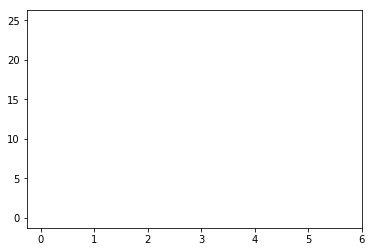

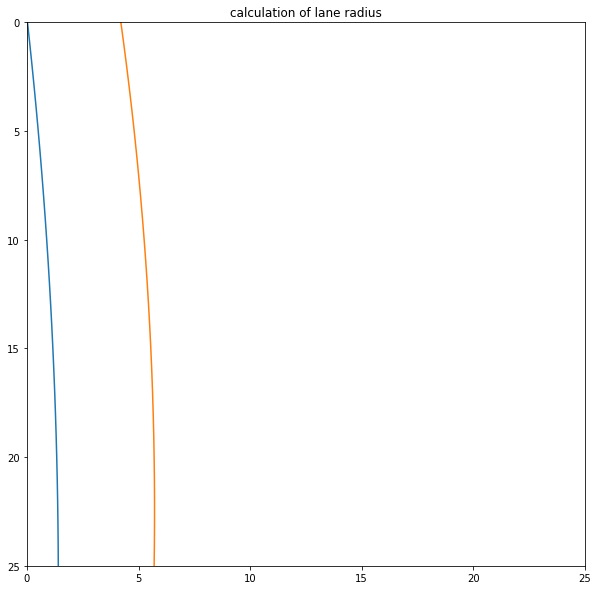

In [18]:
xm_per_pix = 0.0051 # Hard coded based on above calculations
ym_per_pix = 0.0370 # Hard coded based on above calculations

def find_x(curve, y):
    a0, a1, a2 = curve
    return a0*y**2 + a1*y + a2

img = get_test_image()
undistorted = undistort(img)
pts = endpoints_for_perspective_transform()
warped, M, dst = warp(img, pts)

gradx, grady, mag_binary, dir_binary, s_channel_binary, combined = get_thresholds(warped)
binary_warped = combined

# out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped, xm_per_pix, ym_per_pix)
out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, xm_per_pix, ym_per_pix)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


plt.figure(figsize=(10, 10))
axes = plt.gca()
axes.set_xlim([0,25])
axes.set_ylim([25,0])

# left_fitx=left_fitx[::-1]
# right_fitx=right_fitx[::-1]

plt.title('calculation of lane radius')
plt.plot(left_fitx, ploty)
plt.plot(right_fitx, ploty)

print(find_x(left_fit, 0))
print(find_x(right_fit, 0))


height=img.shape[0]
pos=height*ym_per_pix
left_curverad = radius(left_fit, pos)
right_curverad = radius(right_fit, pos)
print(pos, left_curverad, right_curverad)

########################################



In [19]:
a = np.array([1, 2, 3, 4])
b = np.array([9, 9, 9, 9])
print(np.flipud(np.vstack((a, b)).T))

[[4 9]
 [3 9]
 [2 9]
 [1 9]]


In [20]:
def process_image(img):
    undistorted = undistort(img)

    pts = endpoints_for_perspective_transform()
    warped, M, dst = warp(rgb, pts)

    gradx, grady, mag_binary, dir_binary, s_channel_binary, combined = get_thresholds(warped)
    binary_warped = combined
    
    out_img, left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
    layer = np.zeros_like(undistorted)
    coordinates_left = np.vstack((left_fitx.astype(int), ploty.astype(int))).T
    coordinates_right = np.flipud(np.vstack((right_fitx.astype(int), ploty.astype(int))).T)
    coordinates = np.concatenate((coordinates_left, coordinates_right), axis=0)
    cv2.fillPoly(layer, np.array([ coordinates ]), color=(0, 255, 0))
    unwarped, M, dst = unwarp(layer, pts)

    overlay = weighted_img(unwarped, rgb, 0.95, 0.6, 0)

    return overlay

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


 98%|█████████▊| 50/51 [02:16<00:02,  2.74s/it]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 



CPU times: user 6min 32s, sys: 2min 35s, total: 9min 8s
Wall time: 2min 16s


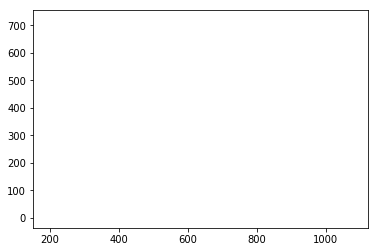

In [22]:
yellow_output = 'output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip2 = VideoFileClip('project_video.mp4').subclip(0,2)
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)